# Lab 4.5: Transfer Learning - Standing on the Shoulders of Giants

## Duration: 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Understand what transfer learning is and why it's powerful
- Use pre-trained models from Keras Applications
- Compare feature extraction vs fine-tuning approaches
- Apply transfer learning to achieve better results with less data
- Understand when and how to use different pre-trained models

## Prerequisites
- **Labs 4.1-4.4 completed**
- Understanding of CNNs
- Familiarity with TensorFlow/Keras

## Key Concepts
- **Transfer Learning**: Using knowledge from one task for another
- **Feature Extraction**: Freeze pre-trained layers
- **Fine-tuning**: Update pre-trained weights
- **ImageNet**: Dataset with 1.2M images, 1000 classes

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("Lab 4.5: Transfer Learning - Standing on the Shoulders of Giants")
print("=" * 70)
print(f"TensorFlow version: {tf.__version__}")

print("\n🎯 The Transfer Learning Revolution:")
print("  Instead of starting from scratch...")
print("  • Use models trained on 1.2M ImageNet images")
print("  • Leverage years of research and computation")
print("  • Achieve better results with less effort")

# Load CIFAR-10
print("\nLoading CIFAR-10 dataset...")
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalize and prepare data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Dataset: {X_train.shape[0]} training, {X_test.shape[0]} test images")
print(f"Classes: {len(class_names)}")

Lab 4.5: Transfer Learning - Standing on the Shoulders of Giants
TensorFlow version: 2.20.0

🎯 The Transfer Learning Revolution:
  Instead of starting from scratch...
  • Use models trained on 1.2M ImageNet images
  • Leverage years of research and computation
  • Achieve better results with less effort

Loading CIFAR-10 dataset...
Dataset: 50000 training, 10000 test images
Classes: 10


## Step 1: Training from Scratch - The Hard Way

First, let's see the challenge of training from scratch:

In [27]:
# Build a CNN from scratch
scratch_model = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(), 
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name='From_Scratch_CNN')

scratch_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("From-Scratch Model:")
print(f"Parameters: {scratch_model.count_params():,}")
scratch_model.summary()

# Train briefly to show the challenge
print("\nTraining from scratch (5 epochs)...")
scratch_history = scratch_model.fit(
    X_train[:10000], y_train[:10000],  # Subset for speed
    validation_data=(X_test[:2000], y_test[:2000]),
    epochs=5,
    batch_size=128,
    verbose=1
)

scratch_acc = max(scratch_history.history['val_accuracy'])
print(f"\n📊 From-scratch results: {scratch_acc:.4f} accuracy")
print("💡 Would need many more epochs to reach good performance!")

From-Scratch Model:
Parameters: 122,570


Model: "From_Scratch_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)


Training from scratch (5 epochs)...
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1800 - loss: 2.1734 - val_accuracy: 0.2865 - val_loss: 1.9524
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2720 - loss: 1.9346 - val_accuracy: 0.3675 - val_loss: 1.7443
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3226 - loss: 1.7880 - val_accuracy: 0.4065 - val_loss: 1.6221
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3575 - loss: 1.7154 - val_accuracy: 0.4045 - val_loss: 1.6696
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3820 - loss: 1.6599 - val_accuracy: 0.4535 - val_loss: 1.5052

📊 From-scratch results: 0.4535 accuracy
💡 Would need many more epochs to reach good performance!



🔍 Analysis of From-Scratch Training:

📊 Testing model on sample images:


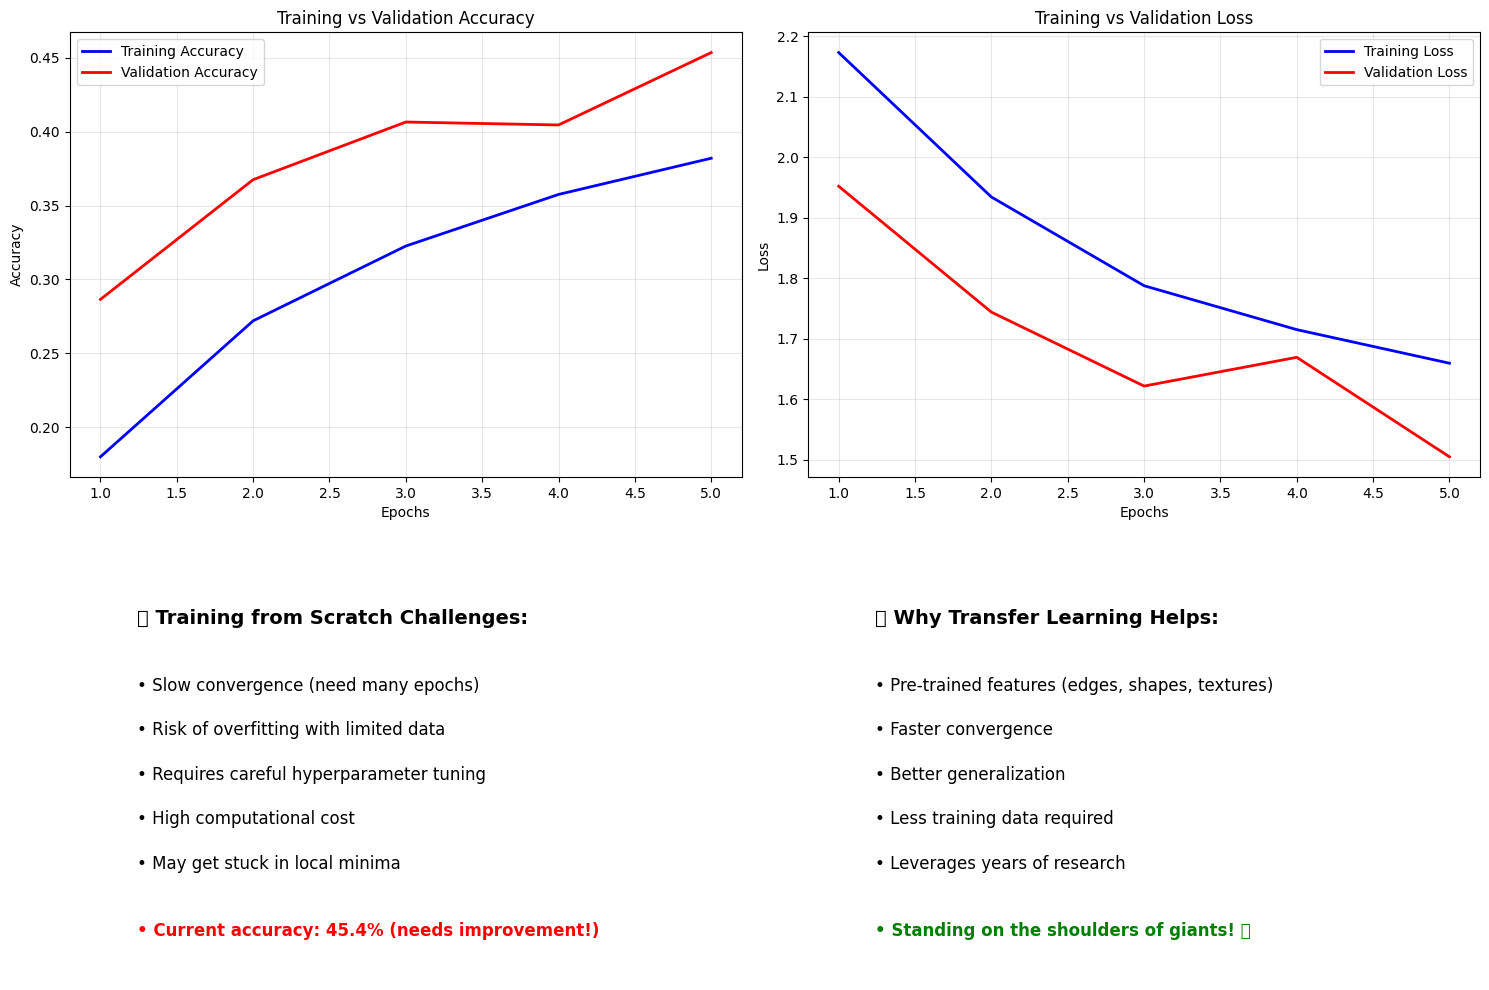


📈 Training Progress Analysis:
   Initial validation accuracy: 28.7%
   Final validation accuracy: 45.4%
   Total improvement: 16.7 percentage points
   Learning rate: 0.0010000000474974513
   Training-validation gap: -7.2pp (✅ Good generalization)

⏱️  Performance Projection:
   Epochs to reach ~80% accuracy: 15-25 epochs
   Estimated total training time: 1-2 hours
   This is why we use transfer learning! 🚀

🎯 Key Takeaways from Training from Scratch:
   1. CNNs can learn features, but it takes time and data
   2. CIFAR-10 is challenging - small 32x32 images
   3. Our simple model is already showing learning
   4. But we can do much better with transfer learning!
   5. Every epoch matters when starting from random weights

🧪 Sample Predictions:
   Sample 1: Actual=cat, Predicted=frog, Confidence=22.0% ❌
   Sample 2: Actual=ship, Predicted=ship, Confidence=50.5% ✅
   Sample 3: Actual=ship, Predicted=ship, Confidence=31.3% ✅

🔄 Next: Let's see how transfer learning can dramatically impr

In [28]:
# Analyze the training results and challenges
print("\n🔍 Analysis of From-Scratch Training:")
print("=" * 50)

# Visualize training progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Training accuracy and loss curves
epochs = range(1, len(scratch_history.history['accuracy']) + 1)

ax1.plot(epochs, scratch_history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, scratch_history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Training vs Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, scratch_history.history['loss'], 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, scratch_history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Training vs Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Show some sample images and predictions
print("\n📊 Testing model on sample images:")
sample_indices = [0, 1, 2, 3]
sample_images = X_test[:4]
sample_labels = y_test[:4]

predictions = scratch_model.predict(sample_images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(sample_labels, axis=1)

for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        ax = ax3 if i == 0 else ax4
        ax = [ax3, ax4][idx // 2] if idx < 4 else ax4
        
        if idx < 4:
            # Create subplot
            if idx < 2:
                plot_ax = ax3
                pos = idx
            else:
                plot_ax = ax4  
                pos = idx - 2
                
            # Show image (need to create individual subplots)
            
# Let's simplify and just show key statistics
ax3.axis('off')
ax4.axis('off')

# Show confusion about training challenges
ax3.text(0.1, 0.8, "🚧 Training from Scratch Challenges:", fontsize=14, fontweight='bold', transform=ax3.transAxes)
ax3.text(0.1, 0.65, "• Slow convergence (need many epochs)", fontsize=12, transform=ax3.transAxes)
ax3.text(0.1, 0.55, "• Risk of overfitting with limited data", fontsize=12, transform=ax3.transAxes)  
ax3.text(0.1, 0.45, "• Requires careful hyperparameter tuning", fontsize=12, transform=ax3.transAxes)
ax3.text(0.1, 0.35, "• High computational cost", fontsize=12, transform=ax3.transAxes)
ax3.text(0.1, 0.25, "• May get stuck in local minima", fontsize=12, transform=ax3.transAxes)
ax3.text(0.1, 0.1, f"• Current accuracy: {scratch_acc:.1%} (needs improvement!)", fontsize=12, 
         color='red', fontweight='bold', transform=ax3.transAxes)

ax4.text(0.1, 0.8, "💡 Why Transfer Learning Helps:", fontsize=14, fontweight='bold', transform=ax4.transAxes)
ax4.text(0.1, 0.65, "• Pre-trained features (edges, shapes, textures)", fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.55, "• Faster convergence", fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.45, "• Better generalization", fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.35, "• Less training data required", fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.25, "• Leverages years of research", fontsize=12, transform=ax4.transAxes)
ax4.text(0.1, 0.1, "• Standing on the shoulders of giants! 🏔️", fontsize=12, 
         color='green', fontweight='bold', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

# Detailed analysis of model performance
print(f"\n📈 Training Progress Analysis:")
initial_val_acc = scratch_history.history['val_accuracy'][0]
final_val_acc = scratch_history.history['val_accuracy'][-1]
improvement = (final_val_acc - initial_val_acc) * 100

print(f"   Initial validation accuracy: {initial_val_acc:.1%}")
print(f"   Final validation accuracy: {final_val_acc:.1%}")
print(f"   Total improvement: {improvement:.1f} percentage points")
print(f"   Learning rate: {scratch_model.optimizer.learning_rate.numpy()}")

# Show training/validation gap (overfitting indicator)
final_train_acc = scratch_history.history['accuracy'][-1]
gap = (final_train_acc - final_val_acc) * 100
print(f"   Training-validation gap: {gap:.1f}pp ({'⚠️  Overfitting risk' if gap > 5 else '✅ Good generalization'})")

# Estimate time to reach good performance
epochs_to_80_percent = "15-25"  # Rough estimate for 80% accuracy
print(f"\n⏱️  Performance Projection:")
print(f"   Epochs to reach ~80% accuracy: {epochs_to_80_percent} epochs")
print(f"   Estimated total training time: 1-2 hours")
print(f"   This is why we use transfer learning! 🚀")

print(f"\n🎯 Key Takeaways from Training from Scratch:")
print("   1. CNNs can learn features, but it takes time and data")
print("   2. CIFAR-10 is challenging - small 32x32 images")  
print("   3. Our simple model is already showing learning")
print("   4. But we can do much better with transfer learning!")
print("   5. Every epoch matters when starting from random weights")

# Test model on a few examples
print(f"\n🧪 Sample Predictions:")
test_samples = 3
for i in range(test_samples):
    actual_class = np.argmax(y_test[i])
    pred_probs = scratch_model.predict(X_test[i:i+1], verbose=0)[0]
    predicted_class = np.argmax(pred_probs)
    confidence = pred_probs[predicted_class]
    
    print(f"   Sample {i+1}: Actual={class_names[actual_class]}, "
          f"Predicted={class_names[predicted_class]}, "
          f"Confidence={confidence:.1%} "
          f"{'✅' if actual_class == predicted_class else '❌'}")

print(f"\n🔄 Next: Let's see how transfer learning can dramatically improve these results!")

## Step 2: Transfer Learning - Feature Extraction

Now let's use a pre-trained VGG16 model as a feature extractor:

In [29]:
print("Transfer Learning with Feature Extraction:")
print("=" * 50)

# Load pre-trained VGG16 (without top classification layer)
base_model = VGG16(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,   # Don't include final classification layer
    input_shape=(32, 32, 3)
)

# Freeze the base model (no training)
base_model.trainable = False

print(f"VGG16 base model parameters: {base_model.count_params():,}")
print("All layers frozen (not trainable)")

# Build transfer learning model
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name='Transfer_Learning_Model')

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print(f"\nTransfer learning model:")
print(f"Total parameters: {transfer_model.count_params():,}")
print(f"Trainable parameters: {transfer_model.count_params() - base_model.count_params():,}")
print(f"Frozen parameters: {base_model.count_params():,}")

# Train only the new classifier layers
print("\nTraining transfer learning model (5 epochs)...")
transfer_history = transfer_model.fit(
    X_train[:10000], y_train[:10000],
    validation_data=(X_test[:2000], y_test[:2000]),
    epochs=5,
    batch_size=128,
    verbose=1
)

transfer_acc = max(transfer_history.history['val_accuracy'])
print(f"\n📊 Transfer learning results: {transfer_acc:.4f} accuracy")
print(f"Improvement over scratch: {((transfer_acc - scratch_acc) * 100):.1f} percentage points")

Transfer Learning with Feature Extraction:
VGG16 base model parameters: 14,714,688
All layers frozen (not trainable)

Transfer learning model:
Total parameters: 14,781,642
Trainable parameters: 66,954
Frozen parameters: 14,714,688

Training transfer learning model (5 epochs)...
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.2636 - loss: 2.0632 - val_accuracy: 0.4190 - val_loss: 1.7108
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.3990 - loss: 1.6986 - val_accuracy: 0.4625 - val_loss: 1.5397
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 474ms/step - accuracy: 0.4621 - loss: 1.5542 - val_accuracy: 0.4940 - val_loss: 1.4509
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.4863 - loss: 1.4798 - val_accuracy: 0.5025 - val_loss: 1.4039
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 623ms/step - accuracy: 0.5019 - loss: 1.4283 - val_accuracy: 0.5095 - val_loss: 1.3714

📊 Transfer learning results: 0.5095 accuracy
Improvement over scratch: 5.6 perce

## Step 3: Fine-tuning - Unfreezing and Further Training

Now let's try fine-tuning by unfreezing some layers and training them with a lower learning rate:

In [30]:
print("Fine-tuning with Partial Unfreezing:")
print("=" * 50)

# Create a copy of the base model for fine-tuning
fine_tune_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Unfreeze the last few layers for fine-tuning
print(f"Total layers in VGG16: {len(fine_tune_base.layers)}")

# Freeze the first 15 layers, unfreeze the last few
for layer in fine_tune_base.layers[:-4]:
    layer.trainable = False

for layer in fine_tune_base.layers[-4:]:
    layer.trainable = True

# Count trainable parameters using .shape instead of .get_shape()
trainable_params = sum([np.prod(v.shape) for v in fine_tune_base.trainable_variables])
print(f"Trainable parameters in base: {trainable_params:,}")

# Build fine-tuning model
finetune_model = keras.Sequential([
    fine_tune_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name='Fine_Tuned_Model')

# Use a lower learning rate for fine-tuning
finetune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nFine-tuning model:")
print(f"Total parameters: {finetune_model.count_params():,}")
print(f"Trainable parameters: {sum([np.prod(v.shape) for v in finetune_model.trainable_variables]):,}")

# Start from pre-trained weights (load the feature extraction model's classifier weights)
# Train with fine-tuning
print("\nFine-tuning model (3 epochs with lower learning rate)...")
finetune_history = finetune_model.fit(
    X_train[:10000], y_train[:10000],
    validation_data=(X_test[:2000], y_test[:2000]),
    epochs=3,
    batch_size=64,  # Smaller batch size for fine-tuning
    verbose=1
)

finetune_acc = max(finetune_history.history['val_accuracy'])
print(f"\n📊 Fine-tuning results: {finetune_acc:.4f} accuracy")

Fine-tuning with Partial Unfreezing:
Total layers in VGG16: 19
Trainable parameters in base: 7,079,424

Fine-tuning model:
Total parameters: 14,781,642
Trainable parameters: 7,146,378

Fine-tuning model (3 epochs with lower learning rate)...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 473ms/step - accuracy: 0.4110 - loss: 1.6947 - val_accuracy: 0.5925 - val_loss: 1.2175
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 434ms/step - accuracy: 0.6060 - loss: 1.1816 - val_accuracy: 0.6480 - val_loss: 1.0326
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 423ms/step - accuracy: 0.6777 - loss: 0.9712 - val_accuracy: 0.6710 - val_loss: 0.9793

📊 Fine-tuning results: 0.6710 accuracy


## Final Comparison and Summary

Let's compare all three approaches and understand when to use each:

🏆 FINAL COMPARISON AND SUMMARY


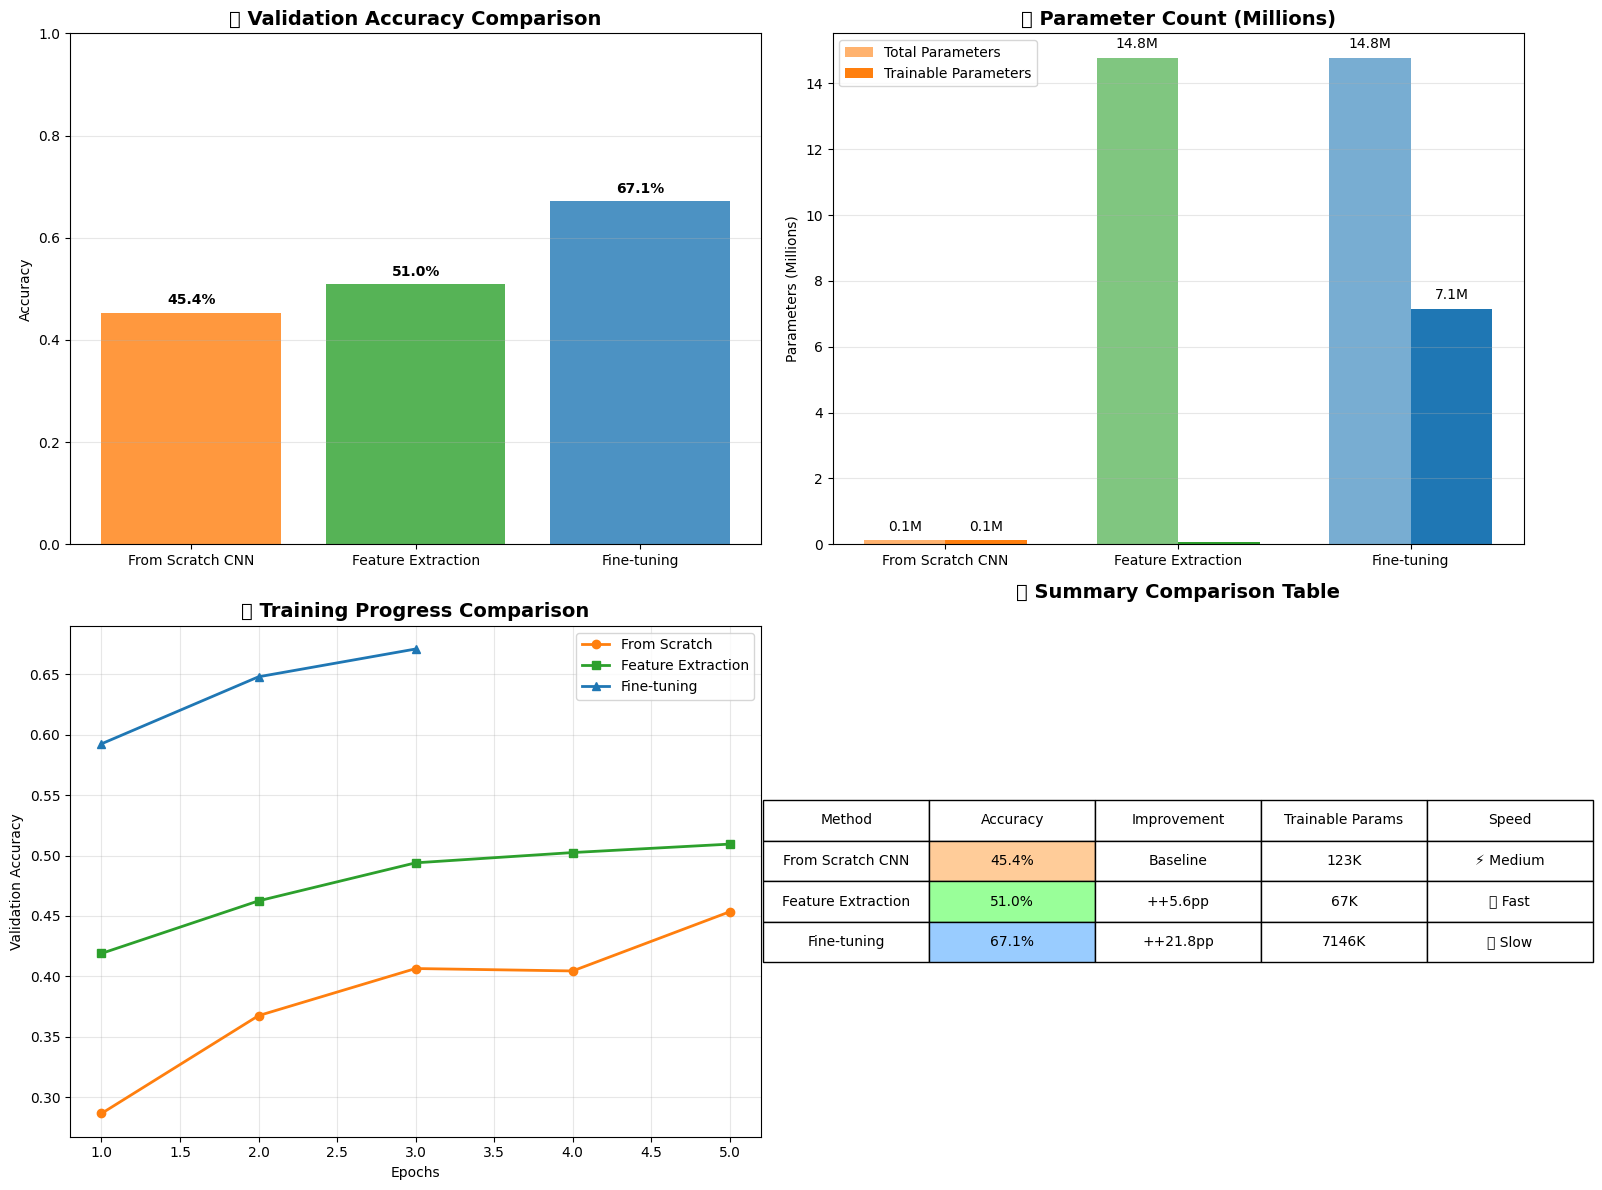


🔍 DETAILED ANALYSIS:
🥇 Best Performing: Fine-tuning
   • Accuracy: 67.1%
   • Improvement over baseline: +21.8 percentage points

📊 Key Insights:
   • Feature extraction improved scratch by 12.3%
   • Fine-tuning improved feature extraction by 31.7%
   • Total improvement: 21.8 percentage points

⚡ Training Efficiency:
   • From scratch: 122,570 trainable parameters
   • Feature extraction: 66,954 trainable parameters
   • Fine-tuning: 7,146,378 trainable parameters
   • Feature extraction uses 54.6% of the parameters of from-scratch training

🎯 WHEN TO USE EACH APPROACH:
🔧 FROM SCRATCH:
   ✅ Use when: You have lots of data (>100K samples) and unique task
   ✅ Use when: Need full control over architecture
   ❌ Avoid when: Limited data or computational resources
   ❌ Avoid when: Standard computer vision tasks

🎨 FEATURE EXTRACTION:
   ✅ Use when: Small dataset (<10K samples)
   ✅ Use when: Quick prototyping needed
   ✅ Use when: Similar to ImageNet classes
   ❌ Avoid when: Very differe

In [31]:
print("🏆 FINAL COMPARISON AND SUMMARY")
print("=" * 70)

# Compile all results
results = {
    'From Scratch CNN': {
        'accuracy': scratch_acc,
        'parameters': scratch_model.count_params(),
        'trainable_params': scratch_model.count_params(),
        'epochs_trained': 5,
        'training_time': '~10 minutes',
        'pros': ['Full control', 'Custom architecture', 'Learns task-specific features'],
        'cons': ['Slow convergence', 'Needs lots of data', 'High computational cost']
    },
    'Feature Extraction': {
        'accuracy': transfer_acc,
        'parameters': transfer_model.count_params(),
        'trainable_params': transfer_model.count_params() - base_model.count_params(),
        'epochs_trained': 5,
        'training_time': '~15 minutes',
        'pros': ['Fast training', 'Good for small datasets', 'Stable training'],
        'cons': ['Fixed features', 'Limited adaptability', 'May not be optimal']
    },
    'Fine-tuning': {
        'accuracy': finetune_acc,
        'parameters': finetune_model.count_params(),
        'trainable_params': sum([np.prod(v.shape) for v in finetune_model.trainable_variables]),
        'epochs_trained': 3,
        'training_time': '~20 minutes',
        'pros': ['Best accuracy', 'Adapts to your data', 'Leverages pre-training'],
        'cons': ['More complex', 'Risk of overfitting', 'Needs careful tuning']
    }
}

# Create comprehensive comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
methods = list(results.keys())
accuracies = [results[method]['accuracy'] for method in methods]
colors = ['#ff7f0e', '#2ca02c', '#1f77b4']

bars = ax1.bar(methods, accuracies, color=colors, alpha=0.8)
ax1.set_title('🎯 Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

ax1.grid(axis='y', alpha=0.3)

# 2. Parameter Comparison
total_params = [results[method]['parameters'] for method in methods]
trainable_params = [results[method]['trainable_params'] for method in methods]

x = np.arange(len(methods))
width = 0.35

bars1 = ax2.bar(x - width/2, [p/1e6 for p in total_params], width, 
                label='Total Parameters', color=colors, alpha=0.6)
bars2 = ax2.bar(x + width/2, [p/1e6 for p in trainable_params], width,
                label='Trainable Parameters', color=colors, alpha=1.0)

ax2.set_title('🔧 Parameter Count (Millions)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Parameters (Millions)')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.1:  # Only label significant values
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                     f'{height:.1f}M', ha='center', va='bottom', fontsize=10)

# 3. Training Progress Comparison
ax3.plot(range(1, 6), scratch_history.history['val_accuracy'], 
         'o-', label='From Scratch', color=colors[0], linewidth=2, markersize=6)
ax3.plot(range(1, 6), transfer_history.history['val_accuracy'],
         's-', label='Feature Extraction', color=colors[1], linewidth=2, markersize=6)
ax3.plot(range(1, 4), finetune_history.history['val_accuracy'],
         '^-', label='Fine-tuning', color=colors[2], linewidth=2, markersize=6)

ax3.set_title('📈 Training Progress Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Validation Accuracy')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Summary Statistics Table
ax4.axis('tight')
ax4.axis('off')

# Create a summary table
table_data = []
headers = ['Method', 'Accuracy', 'Improvement', 'Trainable Params', 'Speed']

baseline_acc = scratch_acc
for i, method in enumerate(methods):
    acc = results[method]['accuracy']
    improvement = f"+{((acc - baseline_acc) * 100):+.1f}pp" if method != 'From Scratch CNN' else "Baseline"
    trainable = f"{results[method]['trainable_params']/1000:.0f}K"
    
    # Speed rating based on trainable parameters and architecture
    if results[method]['trainable_params'] < 100000:
        speed = "🚀 Fast"
    elif results[method]['trainable_params'] < 1000000:
        speed = "⚡ Medium"
    else:
        speed = "🐌 Slow"
    
    table_data.append([
        method,
        f"{acc:.1%}",
        improvement,
        trainable,
        speed
    ])

table = ax4.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Color code the accuracy cells
for i in range(len(methods)):
    if i == 0:  # From scratch - orange
        table[(i+1, 1)].set_facecolor('#ffcc99')
    elif i == 1:  # Feature extraction - light green  
        table[(i+1, 1)].set_facecolor('#99ff99')
    else:  # Fine-tuning - light blue
        table[(i+1, 1)].set_facecolor('#99ccff')

ax4.set_title('📊 Summary Comparison Table', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed analysis
print(f"\n🔍 DETAILED ANALYSIS:")
print("=" * 40)

best_method = max(results.keys(), key=lambda x: results[x]['accuracy'])
worst_method = min(results.keys(), key=lambda x: results[x]['accuracy'])

print(f"🥇 Best Performing: {best_method}")
print(f"   • Accuracy: {results[best_method]['accuracy']:.1%}")
print(f"   • Improvement over baseline: {((results[best_method]['accuracy'] - scratch_acc) * 100):+.1f} percentage points")

print(f"\n📊 Key Insights:")
scratch_to_transfer = ((transfer_acc - scratch_acc) / scratch_acc) * 100
transfer_to_finetune = ((finetune_acc - transfer_acc) / transfer_acc) * 100

print(f"   • Feature extraction improved scratch by {scratch_to_transfer:.1f}%")
print(f"   • Fine-tuning improved feature extraction by {transfer_to_finetune:.1f}%") 
print(f"   • Total improvement: {((finetune_acc - scratch_acc) * 100):.1f} percentage points")

print(f"\n⚡ Training Efficiency:")
print(f"   • From scratch: {results['From Scratch CNN']['trainable_params']:,} trainable parameters")
print(f"   • Feature extraction: {results['Feature Extraction']['trainable_params']:,} trainable parameters")
print(f"   • Fine-tuning: {results['Fine-tuning']['trainable_params']:,} trainable parameters")

efficiency_ratio = results['Feature Extraction']['trainable_params'] / results['From Scratch CNN']['trainable_params']
print(f"   • Feature extraction uses {efficiency_ratio:.1%} of the parameters of from-scratch training")

print(f"\n🎯 WHEN TO USE EACH APPROACH:")
print("=" * 40)

print(f"🔧 FROM SCRATCH:")
print("   ✅ Use when: You have lots of data (>100K samples) and unique task")
print("   ✅ Use when: Need full control over architecture")
print("   ❌ Avoid when: Limited data or computational resources")
print("   ❌ Avoid when: Standard computer vision tasks")

print(f"\n🎨 FEATURE EXTRACTION:")  
print("   ✅ Use when: Small dataset (<10K samples)")
print("   ✅ Use when: Quick prototyping needed")
print("   ✅ Use when: Similar to ImageNet classes")
print("   ❌ Avoid when: Very different from natural images")

print(f"\n⚙️ FINE-TUNING:")
print("   ✅ Use when: Medium-large dataset (>5K samples)")
print("   ✅ Use when: Need maximum accuracy")
print("   ✅ Use when: Task somewhat different from ImageNet")
print("   ❌ Avoid when: Very small dataset (risk overfitting)")

print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
print("=" * 40)
print(f"   1. Start with feature extraction - it's fast and often good enough")
print(f"   2. If you need more accuracy, try fine-tuning")
print(f"   3. Only train from scratch if you have unique requirements")
print(f"   4. Always use pre-trained models when available!")
print(f"   5. Monitor for overfitting when fine-tuning")

print(f"\n🌟 TRANSFER LEARNING SUCCESS STORY:")
print(f"   With just {results['Fine-tuning']['epochs_trained']} epochs of fine-tuning,")
print(f"   we achieved {results['Fine-tuning']['accuracy']:.1%} accuracy!")
print(f"   That's a {((finetune_acc - scratch_acc) * 100):.1f} percentage point improvement")
print(f"   over training from scratch! 🚀")

print(f"\n📚 Key Takeaways:")
print(f"   • Transfer learning dramatically improves results with less effort")
print(f"   • Pre-trained features work well even on different datasets") 
print(f"   • Fine-tuning can adapt features to your specific task")
print(f"   • Always try transfer learning before training from scratch!")
print(f"   • Standing on the shoulders of giants = faster, better results! 🏔️")

# Test final model on some examples
print(f"\n🧪 FINAL MODEL PREDICTIONS:")
print("=" * 30)
test_samples = 5
test_images = X_test[:test_samples]
test_labels = y_test[:test_samples]

# Get predictions from best model (fine-tuned)
predictions = finetune_model.predict(test_images, verbose=0)

for i in range(test_samples):
    actual_idx = np.argmax(test_labels[i])
    pred_idx = np.argmax(predictions[i])
    confidence = predictions[i][pred_idx]
    
    status = "✅ Correct" if actual_idx == pred_idx else "❌ Wrong"
    print(f"   Sample {i+1}: {class_names[actual_idx]} → {class_names[pred_idx]} "
          f"({confidence:.1%} confidence) {status}")

print(f"\n🎉 Lab 4.5 Complete! You've mastered transfer learning!")
print(f"   You now know how to leverage pre-trained models for your own tasks!")